In [1]:
import os
import sys
import json
import glob

from PIL import Image

import re

from scipy.stats import fisher_exact

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

In [2]:
from matplotlib import pyplot
import seaborn as sns

In [3]:
from optimizers import Adan, Lookahead, AGC
from transformers import AutoTokenizer, AutoModel

In [4]:
INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'
PMT_PATH = 'data/environmental/prompt.json'

# 

In [15]:
js = json.load(open(PMT_PATH))
js = {i['file_path'].split('_')[0]: i for i in js.values()}

# load rank data

In [7]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/39552 [00:00<?, ?it/s]

In [10]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]

In [11]:
def format_prompt(prompt):
    
    prompt = prompt.strip()
    
    while re.search(r'(\([\s,\.:;\|]*\))|(\<[\s,\.:;\|]*\>)|(\[[\s,\.:;\|]*\])|(\{[\s,\.:;\|]*\})', prompt):
        prompt = re.sub(r'(\([\s,\.:;\|]*\))|(\<[\s,\.:;\|]*\>)|(\[[\s,\.:;\|]*\])|(\{[\s,\.:;\|]*\})', '', prompt)
    
    prompt = re.sub(r'([\[\(\{\<])\s', r'\1', prompt)
    prompt = re.sub(r'\s([\]\)\}\>])', r'\1', prompt)
    prompt = re.sub(r'\s+', ' ', prompt)
    prompt = re.sub(r'(\s?[,;])+', r',', prompt)
    
    prompt = re.sub(r'^[\.,;\s]+', '', prompt)
    prompt = re.sub(r'[\.,;\s]+$', '', prompt)
    
    return prompt

def remove_weight(prompt):
    prompt = re.sub(':[-\s0-9,\.]*', ', ', prompt)
    prompt = re.sub(r'[\(\[\{\<\>\}\]\)]+', '', prompt)
    return prompt

In [17]:
stats = dict()

for image_1, image_2 in tqdm(ordered_pairs):
    
    # prompt = js[image_1]['positive_prompt']
    prompt = js[image_1]['negative_prompt']
    
    prompt = format_prompt(prompt)
    prompt = remove_weight(prompt)
    prompt = format_prompt(prompt)
    
    for tag in prompt.split(','):
        tag = tag.strip()
        if len(tag) == 0:
            continue
        if tag not in stats:
            stats[tag] = [0, 0]
            
        stats[tag][0] += 1
    
    # prompt = js[image_2]['positive_prompt']
    prompt = js[image_2]['negative_prompt']
    
    prompt = format_prompt(prompt)
    prompt = remove_weight(prompt)
    prompt = format_prompt(prompt)
    
    for tag in prompt.split(','):
        tag = tag.strip()
        if len(tag) == 0:
            continue
        if tag not in stats:
            stats[tag] = [0, 0]
            
        stats[tag][1] += 1

  0%|          | 0/39552 [00:00<?, ?it/s]

In [18]:
df = pd.DataFrame(stats.values(), columns=['num_select', 'num_unselect'])
df['tag'] = stats.keys()
df.set_index('tag', inplace=True)

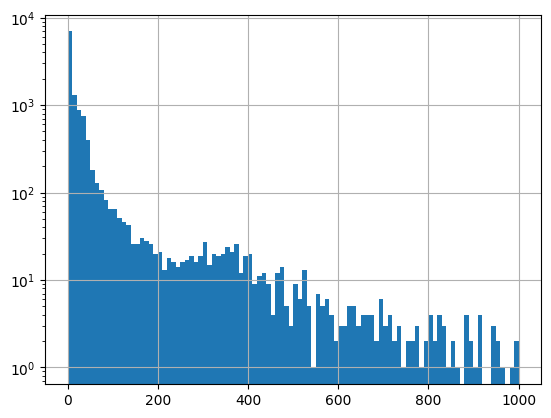

In [19]:
_ = df.eval('num_select	+ num_unselect').hist(bins=100, range=(0, 1000), log=True)

In [20]:
n_total = len(ordered_pairs)

os, ps = list(), list()
for num_select, num_unselect in tqdm(df.itertuples(index=False, name=None), total=df.shape[0]):
    # if num_select + num_unselect < 100:
    #     os.append(-1)
    #     ps.append(-1)
    #     continue
    o, p = fisher_exact([[num_select, num_unselect], [n_total - num_select, n_total - num_unselect]])
    os.append(o)
    ps.append(p)    

  0%|          | 0/11989 [00:00<?, ?it/s]

In [ ]:
df['odds_ratio'] = os
df['p_value'] = ps

# df.to_csv('data/positive_freqs.csv')
df.to_csv('data/negative_freqs.csv')

In [35]:
df.query('num_select > 50 and num_unselect > 50 and p_value < 5e-2').sort_values('odds_ratio').tail(50)

,num_select,num_unselect,odds_ratio,p_value
tag,,,,
overexposure,857,623,1.383921,9.001308e-10
abnormal fingers,260,188,1.385513,7.505516e-04
plain background,197,142,1.389263,3.232641e-03
watermarks,229,165,1.390138,1.432787e-03
black hair,242,174,1.393210,9.664804e-04
wa_lolita,117,84,1.394023,2.358398e-02
cloned face,144,102,1.413269,8.707006e-03
poorly drawn,329,233,1.415473,5.562084e-05
featureless,84,59,1.424631,4.418136e-02
